In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP

plt.rcParams.update({'font.size': 18})


## Data Construction

We simulated a binary dataset consisting of a 1000 data points, the dataset follows a simple linear function $f(x)=mx + c$ where the x is generated randomly from a uniform distribution between $0$ and $1$ and a corresponding y value is calculated with added gaussian noise of mean $\mu=0$ and standard deviation $\sigma=0.25$. Since this dataset is simulated probabilistically by construction the X value of each data point is the probability of that point belonging to class 1.

In [3]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 

In [4]:
z=np.random.random_sample((10000,))
z1=np.random.random_sample((10000,))
z2=np.random.random_sample((10000,))
z3=np.random.random_sample((10000,))
z4=np.random.random_sample((10000,))
z5=np.random.random_sample((10000,))
z6=np.random.random_sample((10000,))
z7=np.random.random_sample((10000,))
z8=np.random.random_sample((10000,))
z9=np.random.random_sample((10000,))
z10=np.random.random_sample((10000,))
z11=np.random.random_sample((10000,))
z12=np.random.random_sample((10000,))
z13=np.random.random_sample((10000,))
z14=np.random.random_sample((10000,))
z15=np.random.random_sample((10000,))
z16=np.random.random_sample((10000,))
z17=np.random.random_sample((10000,))
z18=np.random.random_sample((10000,))
z19=np.random.random_sample((10000,))
z20=np.random.random_sample((10000,))
z21=np.random.random_sample((10000,))

In [20]:
type(Y_test[1])

numpy.float64

In [5]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))
Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y,z,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21), axis=-1)

X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)


scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

'''
plt.figure(figsize=(10,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='b',label='class0',alpha=0.3)
plt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='r',label='class1',alpha=0.2)

plt.axvline(0.1,color='red')
plt.axvline(0.5,color='magenta')
plt.axvline(0.9,color='blue')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ')
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.show()'''


"\nplt.figure(figsize=(10,8))\nplt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='b',label='class0',alpha=0.3)\nplt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='r',label='class1',alpha=0.2)\n\nplt.axvline(0.1,color='red')\nplt.axvline(0.5,color='magenta')\nplt.axvline(0.9,color='blue')\nplt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ')\nplt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )\nplt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )\nplt.legend()\nplt.show()"

In [6]:
X.shape , Y.shape

((10000, 24), (10000,))

In [7]:
X_train.shape , X_test.shape , Y_train.shape , Y_test.shape

((7500, 24), (2500, 24), (7500,), (2500,))

## Bayesian Neural Network Construction to apply variational inference on it by training on the whole training set as opposed to training on mini batches which will be discussed and observed later


A neural network is quite simple. The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. 

We now initialize random weights without biasses between each layer. These normal priors help us regulate the weights which rids us ofof of the need to add a bias constant $b$ to our weights.

Between the layers we will use a $tanh$ activatiopn function and use a $sigmoid$ function which will squeeze the output between zero and one

Network architecture :
- input layer with 2 neurons
- 2 hidden layers with 5 neurons (tanh)
- 1 output layer (sigmoid)

<img src="architecture.png">


We look to observe the reliability curve of the Bayesian neural network

In [8]:

def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network



# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)



In [9]:
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

def reliability_curve(y_true, y_score, bins=10, normalize=False):
 
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

## We now run the MCMC sampler on the whole dataset 

By using pyMC3 packaged MCMC that uses metropolis Hastings algorithm to navigatte the sample space to produce the posterior distribution of the weights


In [10]:

with neural_network:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)



         Current function value: 3812.895098
         Iterations: 406
         Function evaluations: 500
         Gradient evaluations: 489


100%|██████████| 1500/1500 [00:55<00:00, 26.79it/s]


In [7]:
#pm.summary(trace)

# Trace plot of our weights samples from our MCMC 

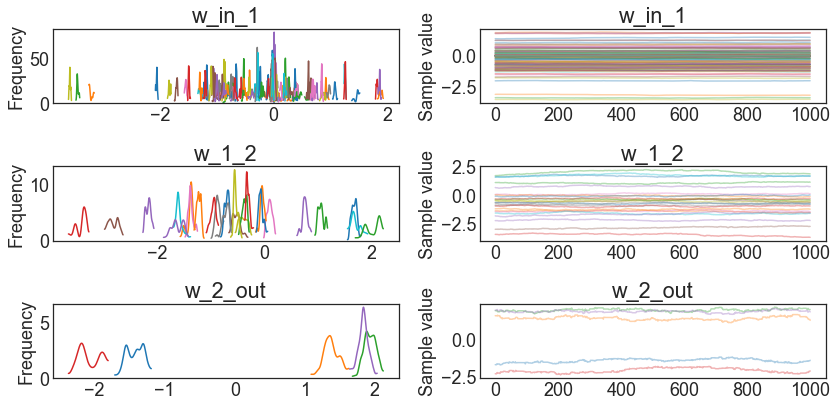

In [9]:
pm.traceplot(trace)
plt.savefig('traceMCMC_long.png')

# We follow with a reliability plot of our Bayesian Neural Network

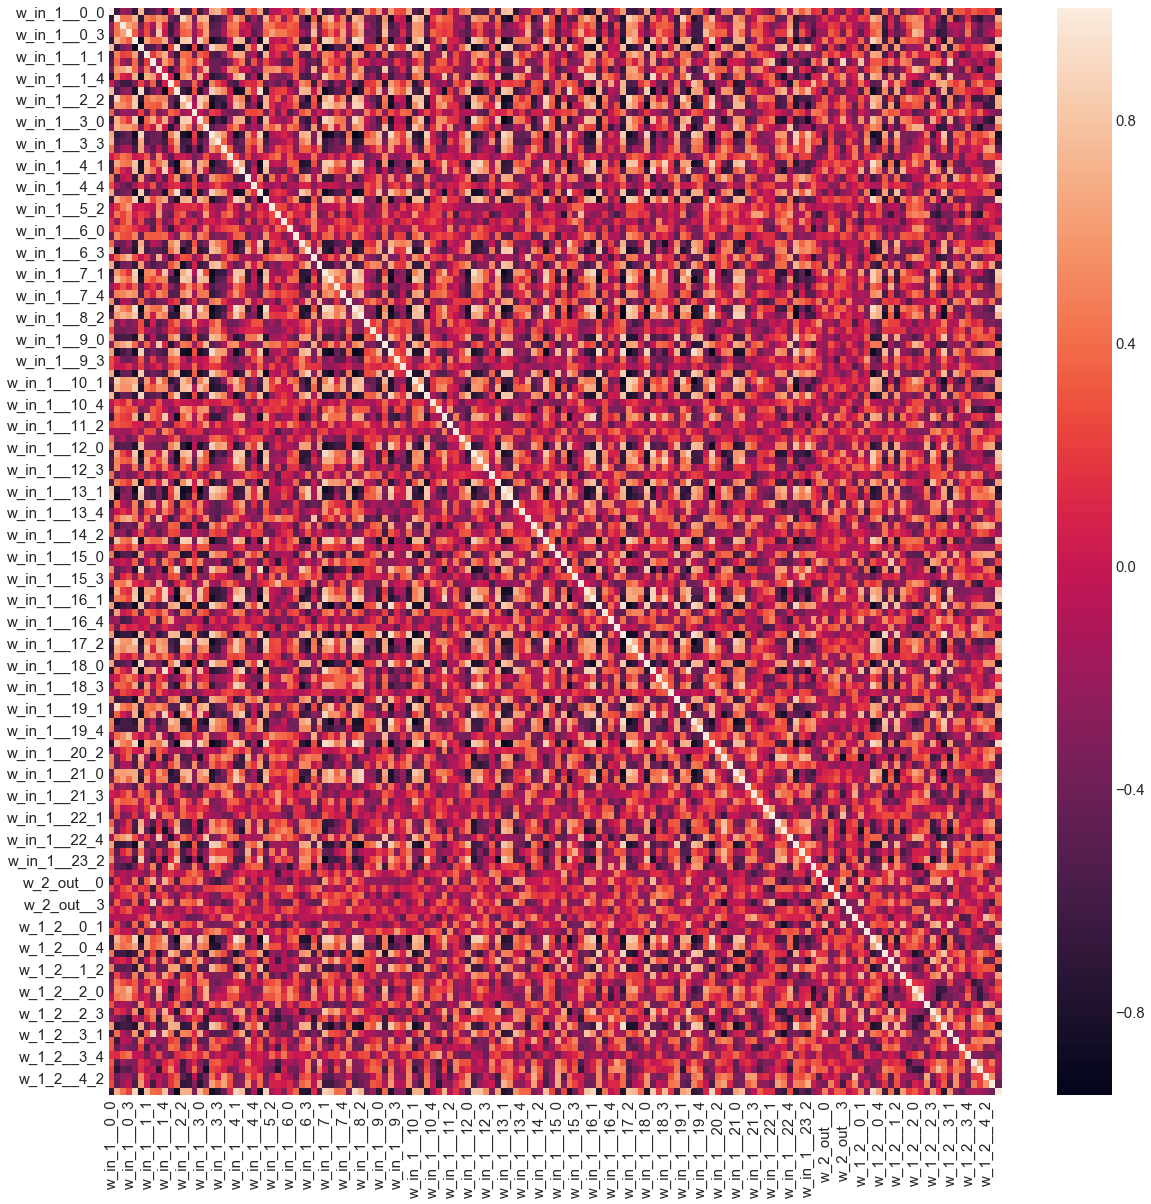

In [10]:
import pandas as pd
import seaborn as sns

df=pm.trace_to_dataframe(trace)

df=df.corr()


plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 15})
sns.heatmap(df)
plt.savefig('correlation_matrix1_long.png')


In [6]:
with neural_network:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sd=1, shape=10)
    
    


In [7]:


with neural_network:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace1 = pm.sample(1000, init=None, step=[step1, step2], cores=2, tune=1000)



Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]
>NUTS: [w_2_out, w_1_2, w_in_1]
100%|██████████| 2000/2000 [2:36:55<00:00,  4.71s/it]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


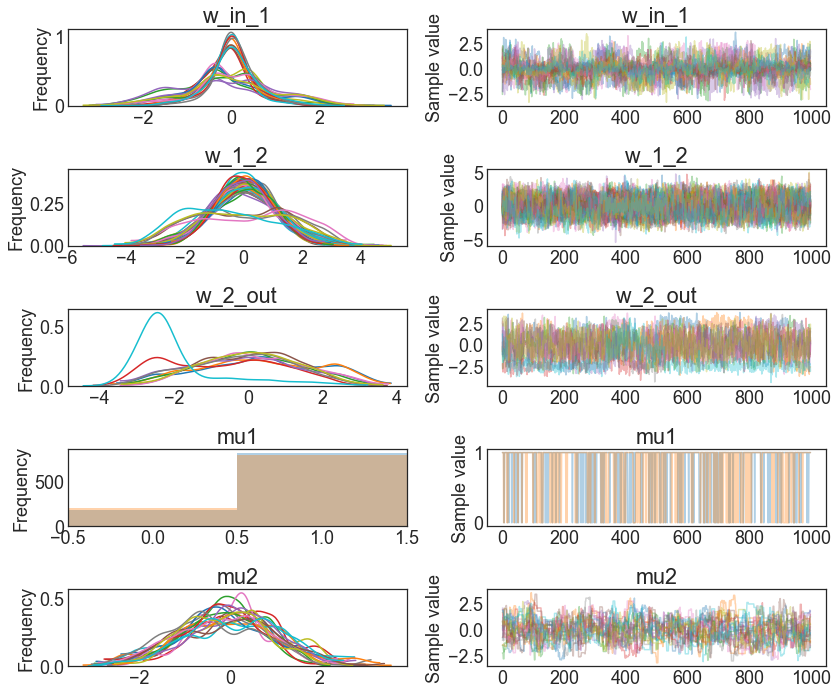

In [8]:
pm.traceplot(trace1)
plt.savefig('trace1MCMC_long1.png')

In [16]:

bins=25

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=1000, progressbar=False)
    

pred = ppc['out'].mean(axis=0) 

pred_binary=pred.astype(int)


y_score['BNN_MCMC'] = ppc['out'].mean(axis=0)
reliability_scores['BNN_MCMC']=\
reliability_curve(Y_test , y_score['BNN_MCMC'], bins=bins , normalize=False)

In [17]:
pred

array([0.886, 0.081, 0.955, ..., 0.8  , 0.166, 0.948])

	Accuracy = 0.7332%
	Precision: 0.741
	Recall: 0.737
	F1: 0.739



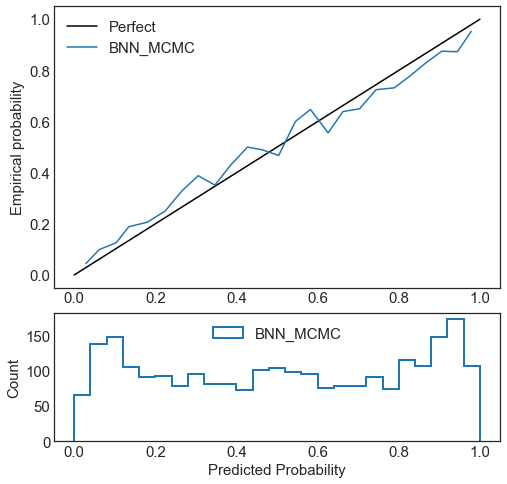

In [13]:
plt.figure(0, figsize=(8, 8))

plt.rcParams.update({'font.size': 15})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)

plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan],'-' ,label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)
plt.savefig('reliabilityBNN_MCMC_line1.png')


print('\tAccuracy = {}%'.format((Y_test == pred).mean() ))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred_binary))
print("\tRecall: %1.3f" % recall_score(Y_test, pred_binary))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred_binary))

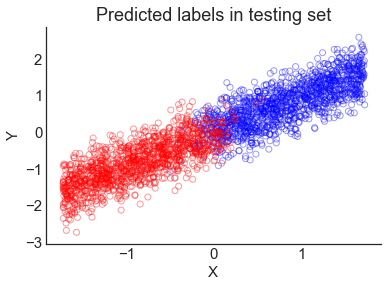

In [30]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1],facecolor='none' ,color='b',alpha=0.4)
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1],facecolor='none', color='r',alpha=0.4)
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y')
plt.savefig('predictelabels.png')

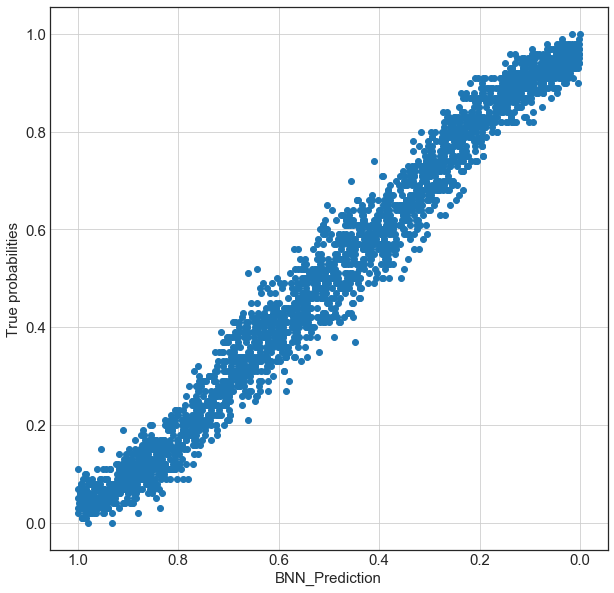

In [31]:

pred_prob=ppc['out'].mean(axis=0)
X_true=scaler.inverse_transform(X_test,copy=None)


plt.figure(figsize=(10,10))
plt.scatter(X_true[:,0],pred_prob)
plt.xlabel('BNN_Prediction')
plt.ylabel('True probabilities')
plt.grid()
#plt.savefig('pred0.png')
plt.gca().invert_xaxis()
plt.show()

In [34]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)



ValueError: Shape mismatch: x has 2 cols (and 10000 rows) but y has 3 rows (and 5 cols)
Apply node that caused the error: Dot22(<TensorType(float64, matrix)>, w_in_1)
Toposort index: 0
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(10000, 2), (3, 5)]
Inputs strides: [(8, 80000), (40, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Tanh}[(0, 0)](Dot22.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-22a13f061588>", line 49, in <module>
    neural_network = construct_nn(ann_input, ann_output)
  File "<ipython-input-21-22a13f061588>", line 28, in construct_nn
    weights_in_1))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

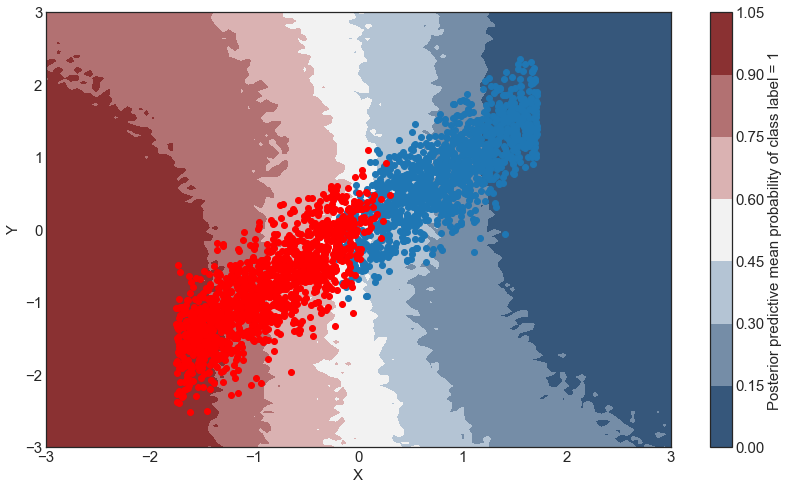

In [16]:

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');
plt.savefig('predictive_prob_MCMC.png')

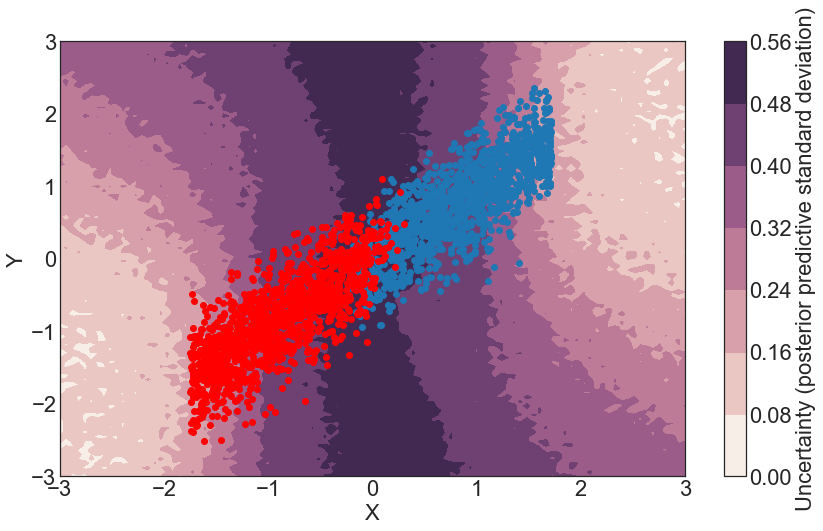

In [17]:
plt.rcParams.update({'font.size': 22})

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')
plt.savefig('uncertainty_post_MCMC.png')



In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,pred)

array([[921, 317],
       [291, 971]])

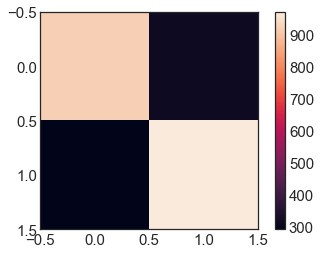

In [29]:
plt.imshow(confusion_matrix(Y_test,pred))
plt.colorbar()
plt.show()